In [16]:
from surrogate_schema import APIClient

%load_ext dotenv
%dotenv

# typical block to authenticate to the API
client = APIClient(api_url="https://api.elementa.nyc")
client.whoami()  # shows that you are properly authenticated

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


User(username='s.letellierduchesne', email='sam@cabonsignal.com', full_name='Samuel Letellier-Duchesne', disabled=None, valid_until=datetime.datetime(2025, 1, 29, 20, 28, 26))

# Exploring Results and Debugging

In this notebook, we are going to look at how we can explore the different models that were generated to identify what could have gone wrong in the model.

First, let's load our analysis from the file named `analysis_1.json`:

In [17]:
from surrogate_schema import BuildingAnalysis

with open("analysis_1.json", "r") as f:
    analysis_1 = BuildingAnalysis.model_validate_json(f.read())

In [18]:
df = analysis_1.sampled_space.to_df()
df

,WWR,WINU,WINSHGC,ROOFR,WALLR,INFIL
0,0.35,0.17,0.2,30.0,10.0,0.01
1,0.35,0.17,0.2,30.0,10.0,0.07
2,0.35,0.17,0.2,30.0,20.0,0.01
3,0.35,0.17,0.2,30.0,30.0,0.01
4,0.35,0.17,0.2,30.0,30.0,0.07
...,...,...,...,...,...,...
1718,0.55,0.38,0.4,50.0,25.0,0.04
1719,0.55,0.38,0.4,50.0,25.0,0.07
1720,0.55,0.38,0.4,50.0,30.0,0.01
1721,0.55,0.38,0.4,50.0,30.0,0.04


We can quickly index the dataframe with a condition. We are looking to het the row 
that has the **WWR** column equal to `90`:

In [19]:
df.loc[df["WWR"] == 0.35]

,WWR,WINU,WINSHGC,ROOFR,WALLR,INFIL
0,0.35,0.17,0.2,30.0,10.0,0.01
1,0.35,0.17,0.2,30.0,10.0,0.07
2,0.35,0.17,0.2,30.0,20.0,0.01
3,0.35,0.17,0.2,30.0,30.0,0.01
4,0.35,0.17,0.2,30.0,30.0,0.07
...,...,...,...,...,...,...
357,0.35,0.38,0.4,50.0,20.0,0.07
358,0.35,0.38,0.4,50.0,25.0,0.01
359,0.35,0.38,0.4,50.0,30.0,0.01
360,0.35,0.38,0.4,50.0,30.0,0.04


Let's download this model and parse it using `archetypal`.

To download the file, we are going to use the analysis's class Client attribute which exposes REST API methods to the API. We are interested in using the `/downloadfile/` entrypoint which requires a `s3_file_path` parameter (see the entrypoint's [documentation](https://api.elementa.nyc/docs#/default/download_file_downloadfile__get) for more information).

In [20]:
request = analysis_1.get_client().get(
    "/downloadfile/",
    params={"s3_file_path": f"{analysis_1.job[0].parameters.idf_output_dir}in_3.idf"},
)

# save the downloaded content to a file named `in_0.idf`
with open("in_3.idf", "wb") as f:
    f.write(request.content)

In [21]:
from archetypal import IDF

idf = IDF("in_3.idf", epw=analysis_1.local_epw)

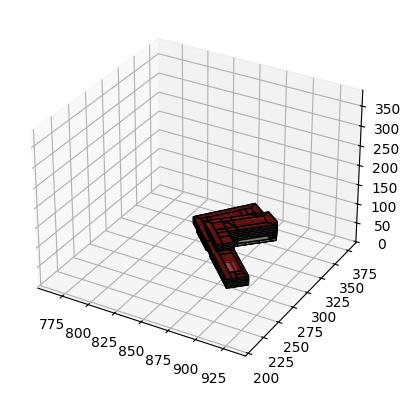

(<Figure size 640x480 with 1 Axes>, [<Axes3D: >])

In [22]:
idf.view_model()

In [23]:
RUN = 40

request = analysis_1.get_client().get(
    "/downloadfile/",
    params={
        "s3_file_path": f"{analysis_1.job[0].parameters.idf_output_dir}in_{RUN}.idf"
    },
)

# save the downloaded content to a file named `in_0.idf`
with open(f"in_{RUN}.idf", "wb") as f:
    f.write(request.content)

In [24]:
from archetypal import IDF

idf40 = IDF("in_40.idf", epw=analysis_1.local_epw)

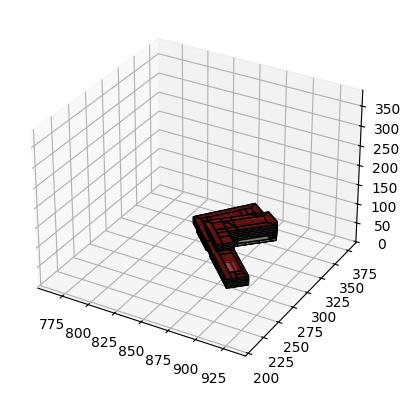

(<Figure size 640x480 with 1 Axes>, [<Axes3D: >])

In [25]:
idf40.view_model()

In [26]:
from eppy.useful_scripts.idfdiff import idfdiffs, makecsvdiffs, printcsv

In [ ]:
thediffs = idfdiffs(idf, idf40)
csvdiffs = makecsvdiffs(thediffs, idf, idf40)

In [ ]:
printcsv(csvdiffs)

## WWR

In [27]:
idf.wwr()

/Users/samueld/PycharmProjects/surrogate-api/.venv/lib/python3.9/site-packages/archetypal/idfclass/idf.py:1813: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df["wwr"] = (df.window_area / df.wall_area).fillna(0).apply(round, 2)


,wall_area,window_area,wwr,wwr_rounded_%
Azimuth,,,,
130,2682.2,938.8,0.350011,40
220,3127.8,1094.7,0.349990,30
310,2593.8,907.8,0.349988,30
40,3113.4,1089.7,0.350003,40
60,232.4,81.3,0.349828,30
0,0.0,0.0,0.000000,0


In [28]:
idf40.wwr()

/Users/samueld/PycharmProjects/surrogate-api/.venv/lib/python3.9/site-packages/archetypal/idfclass/idf.py:1813: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df["wwr"] = (df.window_area / df.wall_area).fillna(0).apply(round, 2)


,wall_area,window_area,wwr,wwr_rounded_%
Azimuth,,,,
130,2682.2,938.8,0.350011,40
220,3127.8,1094.7,0.349990,30
310,2593.8,907.8,0.349988,30
40,3113.4,1089.7,0.350003,40
60,232.4,81.3,0.349828,30
0,0.0,0.0,0.000000,0


In [29]:
idf.total_building_area

23728.075239024532

In [30]:
idf40.total_building_area

23728.075239024532

In [ ]:
idf.simulate()

In [ ]:
from archetypal.idfclass.sql import Sql

sql = Sql(idf.sql_file)

In [ ]:
sql.available_outputs

In [ ]:
idf.idfobjects["SIMULATIONCONTROL"]

In [ ]:
sql.timeseries_by_name(
    *("Cooling:DistrictCooling", "Hourly"), environment_type=3
).plot()

In [ ]:
zonetemp = sql.timeseries_by_name(*("Zone Air Temperature", "Hourly"))
hstp = sql.timeseries_by_name(*(
    "Zone Thermostat Heating Setpoint Temperature",
    "Hourly",
))
cstp = sql.timeseries_by_name(*(
    "Zone Thermostat Cooling Setpoint Temperature",
    "Hourly",
))

In [ ]:
len(idf.idfobjects["ZONE"])

In [ ]:
len(idf.idfobjects["THERMOSTATSETPOINT:DUALSETPOINT"])

In [ ]:
import numpy as np
import pandas as pd

df = (
    pd.concat([zonetemp, hstp, cstp], axis=1)
    .droplevel("IndexGroup", axis=1)
    .reorder_levels([1, 0], axis=1)
)
df.replace({0: np.NaN}, inplace=True)

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

zone_name = widgets.Dropdown(
    options={a[:-2] for a in set(df.columns.get_level_values("KeyValue"))}
)
zone_name

In [ ]:
def plot(zone_name, date_range):
    start, end = date_range
    df.filter(like=zone_name).loc[start:end].plot(legend=False)

In [ ]:
from datetime import datetime

start_date = datetime(2018, 1, 1)
end_date = datetime(2018, 12, 31)

dates = pd.date_range(start_date, end_date, freq="D")

options = [(date.strftime(" %d %b %Y "), date) for date in dates]
index = (0, len(options) - 1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description="Dates",
    orientation="horizontal",
    layout={"width": "500px"},
)

In [ ]:
interact(plot, zone_name=zone_name, date_range=selection_range_slider)

In [ ]:
import plotly.express as px

fig = px.line(
    df.filter(like=zone_name.value)
    .melt(ignore_index=False)
    .reset_index()
    .dropna(subset="value"),
    x="index",
    y="value",
    color="Name",
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()